In [4]:
%matplotlib inline
import math
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

!pip install dmba
from dmba import classificationSummary

!pip install scikit-plot
import scikitplot as skplt
!pip install dmba
from dmba import plotDecisionTree, regressionSummary, classificationSummary, liftChart, gainsChart, adjusted_r2_score, exhaustive_search, backward_elimination, forward_selection, AIC_score, BIC_score

#DRIVACT - Logistic Regression

In [6]:
KSI = pd.read_csv('KSI.csv')

In [7]:
KSI_d = KSI.loc[:,['ACCLASS','INVTYPE','DRIVACT']]
KSI_d

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
1,Fatal,Pedestrian,<Null>
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
...,...,...,...
16855,Non-Fatal Injury,Cyclist,<Null>
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly
16858,Non-Fatal Injury,Passenger,<Null>


In [8]:
objdtype_cols = KSI_d.select_dtypes(["object"]).columns
KSI_d[objdtype_cols] = KSI_d[objdtype_cols].astype('category')

In [9]:
driver = KSI_d[KSI_d['INVTYPE'].str.contains('Driver')]
driver

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
7,Non-Fatal Injury,Driver,Failed to Yield Right of Way
...,...,...,...
16853,Non-Fatal Injury,Motorcycle Driver,Driving Properly
16854,Non-Fatal Injury,Driver,Improper Passing
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly


In [72]:
driver['ACCLASS'] = np.where(driver['ACCLASS'].str.contains('Non-Fatal','Property Damage Only'), 0, 1)
driver

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ACCLASS,INVTYPE,DRIVACT
0,1,Driver,Failed to Yield Right of Way
2,1,Motorcycle Driver,Disobeyed Traffic Control
3,1,Driver,Driving Properly
4,1,Driver,Other
7,0,Driver,Failed to Yield Right of Way
...,...,...,...
16853,0,Motorcycle Driver,Driving Properly
16854,0,Driver,Improper Passing
16856,0,Driver,Failed to Yield Right of Way
16857,0,Driver,Driving Properly


In [10]:
driver = driver[driver.DRIVACT != '<Null>']
driver

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
7,Non-Fatal Injury,Driver,Failed to Yield Right of Way
...,...,...,...
16853,Non-Fatal Injury,Motorcycle Driver,Driving Properly
16854,Non-Fatal Injury,Driver,Improper Passing
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly


In [74]:
X = pd.get_dummies(driver['DRIVACT'],drop_first=True)
y = driver['ACCLASS']

In [75]:
X

,Disobeyed Traffic Control,Driving Properly,Exceeding Speed Limit,Failed to Yield Right of Way,Following too Close,Improper Lane Change,Improper Passing,Improper Turn,Lost control,Other,Speed too Fast For Condition,Speed too Slow,Wrong Way on One Way Road
0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16853,0,1,0,0,0,0,0,0,0,0,0,0,0
16854,0,0,0,0,0,0,1,0,0,0,0,0,0
16856,0,0,0,1,0,0,0,0,0,0,0,0,0
16857,0,1,0,0,0,0,0,0,0,0,0,0,0


In [110]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.3, random_state=50)

In [111]:
log_reg=LogisticRegression(C=1e42, random_state=1, solver='liblinear')
log_reg.fit(train_X,train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [112]:
print('intercept',log_reg.intercept_)
print(pd.DataFrame({'coef':log_reg.coef_[0],'odds':np.e**log_reg.coef_[0]},index=X.columns))

intercept [-1.83103402]
                                  coef      odds
Disobeyed Traffic Control    -0.072623  0.929952
Driving Properly             -0.065945  0.936182
Exceeding Speed Limit         0.862473  2.369012
Failed to Yield Right of Way -0.324743  0.722713
Following too Close          -2.561911  0.077157
Improper Lane Change         -0.732947  0.480491
Improper Passing             -0.456168  0.633707
Improper Turn                -0.601468  0.548007
Lost control                  0.219601  1.245580
Other                        -0.017220  0.982927
Speed too Fast For Condition -0.357533  0.699399
Speed too Slow                1.831235  6.241590
Wrong Way on One Way Road     0.446214  1.562385


In [113]:
log_reg_prob = log_reg.predict_proba(valid_X)
log_reg_pred = log_reg.predict(valid_X)

In [114]:
log_result=pd.DataFrame({'actual':valid_y,
                         'predicted':log_reg_pred,
                         'p_0':[p[0] for p in log_reg_prob],
                         'p_1':[p[1] for p in log_reg_prob]})
log_result

,actual,predicted,p_0,p_1
12936,0,0,0.833610,0.166390
3061,0,0,0.928507,0.071493
9568,1,0,0.869549,0.130451
15813,0,0,0.863922,0.136078
2542,0,0,0.870305,0.129695
...,...,...,...,...
12287,0,0,0.869549,0.130451
10929,0,0,0.869549,0.130451
1195,1,0,0.869549,0.130451
10159,0,0,0.869549,0.130451


In [115]:
classes=['Non-Fatal','Fatal']
classificationSummary(log_result.actual, log_result.predicted,class_names=classes)

Confusion Matrix (Accuracy 0.8653)

          Prediction
   Actual Non-Fatal     Fatal
Non-Fatal      2196         1
    Fatal       341         1


#DRIVACT-Discriminant Analysis

In [34]:
KSI = pd.read_csv('KSI.csv')

In [35]:
KSI_d = KSI.loc[:,['ACCLASS','INVTYPE','DRIVACT']]

In [36]:
objdtype_cols = KSI_d.select_dtypes(["object"]).columns
KSI_d[objdtype_cols] = KSI_d[objdtype_cols].astype('category')

In [37]:
driver = KSI_d[KSI_d['INVTYPE'].str.contains('Driver')]

In [38]:
driver = driver[driver.DRIVACT != '<Null>']
driver

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
7,Non-Fatal Injury,Driver,Failed to Yield Right of Way
...,...,...,...
16853,Non-Fatal Injury,Motorcycle Driver,Driving Properly
16854,Non-Fatal Injury,Driver,Improper Passing
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly


In [39]:
lda_reg = LinearDiscriminantAnalysis()

In [40]:
driver1=pd.get_dummies(driver['DRIVACT'],drop_first=True)
driver1

,Disobeyed Traffic Control,Driving Properly,Exceeding Speed Limit,Failed to Yield Right of Way,Following too Close,Improper Lane Change,Improper Passing,Improper Turn,Lost control,Other,Speed too Fast For Condition,Speed too Slow,Wrong Way on One Way Road
0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16853,0,1,0,0,0,0,0,0,0,0,0,0,0
16854,0,0,0,0,0,0,1,0,0,0,0,0,0
16856,0,0,0,1,0,0,0,0,0,0,0,0,0
16857,0,1,0,0,0,0,0,0,0,0,0,0,0


In [41]:
driver1['ACCLASS']=driver.ACCLASS
driver1

,Disobeyed Traffic Control,Driving Properly,Exceeding Speed Limit,Failed to Yield Right of Way,Following too Close,Improper Lane Change,Improper Passing,Improper Turn,Lost control,Other,Speed too Fast For Condition,Speed too Slow,Wrong Way on One Way Road,ACCLASS
0,0,0,0,1,0,0,0,0,0,0,0,0,0,Fatal
2,1,0,0,0,0,0,0,0,0,0,0,0,0,Fatal
3,0,1,0,0,0,0,0,0,0,0,0,0,0,Fatal
4,0,0,0,0,0,0,0,0,0,1,0,0,0,Fatal
7,0,0,0,1,0,0,0,0,0,0,0,0,0,Non-Fatal Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16853,0,1,0,0,0,0,0,0,0,0,0,0,0,Non-Fatal Injury
16854,0,0,0,0,0,0,1,0,0,0,0,0,0,Non-Fatal Injury
16856,0,0,0,1,0,0,0,0,0,0,0,0,0,Non-Fatal Injury
16857,0,1,0,0,0,0,0,0,0,0,0,0,0,Non-Fatal Injury


In [42]:
lda_reg.fit(driver1.drop(columns=['ACCLASS']), driver1['ACCLASS'])

LinearDiscriminantAnalysis()

In [43]:
print('Coefficients and intercept')

fct = pd.DataFrame([lda_reg.intercept_], columns=lda_reg.classes_, index=['constant'])
fct = fct.append(pd.DataFrame(lda_reg.coef_.transpose(), columns=lda_reg.classes_,
index=list(driver1.columns)[:-1]))
print(fct)

print()
classificationSummary(driver1['ACCLASS'],
lda_reg.predict(driver1.drop(columns=['ACCLASS'])),
class_names=lda_reg.classes_)

Coefficients and intercept
                                 Fatal  Non-Fatal Injury  Property Damage Only
constant                     -2.110834         -0.137044            -13.734113
Disobeyed Traffic Control     0.002825         -0.000135             -1.029456
Driving Properly              0.043972         -0.006466              0.063308
Exceeding Speed Limit         1.285037         -0.188171             -1.041386
Failed to Yield Right of Way -0.157641          0.023397             -1.027963
Following too Close          -0.874657          0.128547             -1.021292
Improper Lane Change         -0.241466          0.035690             -1.027183
Improper Passing             -0.338795          0.049963             -1.026277
Improper Turn                -0.367298          0.054143             -1.026012
Lost control                  0.335863         -0.048975             -1.032555
Other                         0.067568         -0.009630             -1.030058
Speed too Fast For Condit

#Visualization

In [134]:
KSI = pd.read_csv('KSI.csv')

In [137]:
KSI_d = KSI.loc[:,['ACCLASS','INVTYPE','DRIVACT']]

In [138]:
driver = KSI_d[KSI_d['INVTYPE'].str.contains('Driver')]
driver

,ACCLASS,INVTYPE,DRIVACT
0,Fatal,Driver,Failed to Yield Right of Way
2,Fatal,Motorcycle Driver,Disobeyed Traffic Control
3,Fatal,Driver,Driving Properly
4,Fatal,Driver,Other
7,Non-Fatal Injury,Driver,Failed to Yield Right of Way
...,...,...,...
16853,Non-Fatal Injury,Motorcycle Driver,Driving Properly
16854,Non-Fatal Injury,Driver,Improper Passing
16856,Non-Fatal Injury,Driver,Failed to Yield Right of Way
16857,Non-Fatal Injury,Driver,Driving Properly


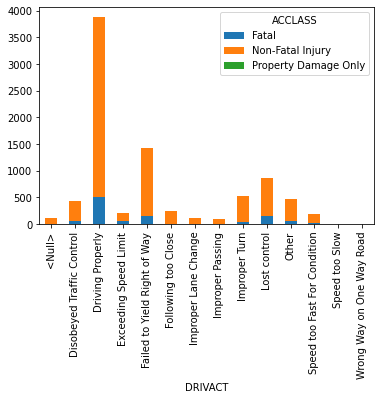

In [139]:
test = driver.groupby(['ACCLASS', 'DRIVACT'])['DRIVACT'].count().unstack('ACCLASS').fillna(0)
test.plot(kind='bar', stacked=True)